In [124]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import math
from keras import backend as K 
import os
import json
from keras.models import load_model

In [125]:
K.clear_session()

In [126]:
from keras.models import model_from_json
json_file = open("/Users/az02234/Documents/Projets_Renault/PredictiveMaintenance/PredictiveMaintenanceAutoEncoder/models/model_autoencoder.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model_autoencoder = model_from_json(loaded_model_json)
model_autoencoder.load_weights("/Users/az02234/Documents/Projets_Renault/PredictiveMaintenance/PredictiveMaintenanceAutoEncoder/models/weight_autoencoder.h5")

In [127]:
model_autoencoder

In [128]:
with open(path + 'metadata_'+name+'.json', 'r') as json_file:
    metadata_autoencoder = json.load(json_file)
json_file.close()
metadata_autoencoder = eval(metadata_autoencoder)

In [129]:
import warnings
warnings.filterwarnings("ignore")
import math
import os

import pandas as pd
import numpy as np


def main_data_processing(data, max_length='auto'):
    if max_length=='auto':
        max_length, num_serie = compute_max_sequence_length(data)

    data["micro_second"] = data.sourceTimestamp_dtformat.dt.microsecond \
                           + data.sourceTimestamp_dtformat.dt.second * 1000 \
                           + data.sourceTimestamp_dtformat.dt.minute * 1000 * 60 \
                           + data.sourceTimestamp_dtformat.dt.hour * 1000 * 60 * 60 \
                           + data.sourceTimestamp_dtformat.dt.day * 1000 * 60 * 60 * 24

    data = data.groupby("pji").apply(normalise)
    data = data.groupby("pji").apply(compute_lag)
    data = data.reset_index(drop=True)
    data = data.fillna(0)
    data = padding(data, max_length)
    return data, max_length


def compute_max_sequence_length(dataframe):
    lengths = dataframe.groupby("pji").count()
    num_serie = lengths.shape[0]
    max_length = lengths.max()[0]
    return max_length, num_serie


def normalise(dataframe):
    dataframe["micro_second"] = dataframe["micro_second"]/1000
    dataframe["normalized_time"] = (dataframe["micro_second"] - dataframe["micro_second"].min()) / dataframe["micro_second"].max()
    return dataframe


def compute_lag(dataframe):
    dataframe.sort_values(by=["normalized_time"], inplace=True)
    dataframe['interval'] = dataframe["micro_second"] - dataframe["micro_second"].shift()
    return dataframe


def padding(data, max_length):
    data_for_dl = []
    for vehicle_id in data.pji.drop_duplicates():
        # select vehicle data
        selector = (data.pji == vehicle_id)
        vehicle_data = data.loc[selector, ['dataValue', 'normalized_time', 'interval']]

        # compute length of the padding
        padding_length = max_length - vehicle_data.shape[0]

        # add padding
        pad = (np.repeat(np.array([0, 1, 0]).reshape(-1, 1), padding_length, axis=1)).T
        vehicle_data = np.vstack((vehicle_data, pad))

        # Append to final array
        data_for_dl.append(list(vehicle_data))
    data_for_dl = np.array(data_for_dl)
    return data_for_dl

In [130]:
os.chdir('/users/az02234/Documents/Projets_Renault/PredictiveMaintenance/PredictiveMaintenanceAutoEncoder/data/interim/')

data = pd.read_csv("data_dl.csv", dtype={'dataValue': np.float64, 'pji': np.int64},
                   parse_dates=['sourceTimestamp_dtformat'], nrows=10000)

data_dl, max_length = main_data_processing(data, max_length=metadata_autoencoder["max_serie_length"])

ValueError: negative dimensions are not allowed

In [ ]:
n_s_encoder = 32
n_s_decoder = 32

In [ ]:
s0_encoder = np.random.randn(num_serie, n_s_encoder)
c0_encoder = np.random.randn(num_serie, n_s_encoder)
s0_decoder = np.random.randn(num_serie, n_s_decoder)
c0_decoder = np.random.randn(num_serie, n_s_decoder)

In [ ]:
predictions = model.predict([data_dl, s0_encoder, c0_encoder, s0_decoder, c0_decoder])

In [46]:
predictions.shape

(37, 598, 1)

In [61]:
predictions2 = predictions[0,:,:]

In [62]:
predictions2.shape

(598, 1)

In [58]:
data_dl2 = data_dl[0,:,0].reshape(-1,1)

In [59]:
data_dl2.shape

(598, 1)

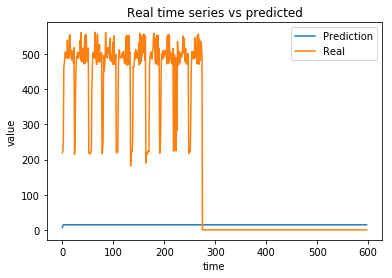

In [64]:
plt.plot(predictions2)
plt.plot(data_dl2)
plt.title('Real time series vs predicted')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['Prediction', 'Real'], loc='upper right')
plt.show()

In [93]:
path='/Users/az02234/Documents/Projets_Renault/PredictiveMaintenance/PredictiveMaintenanceAutoEncoder/models/'
name='autoencoder'

In [68]:
metadata_json = {'num_serie': 1, 'compression_size': 2, 'max_serie_length': 3 }
metadata_json = str(metadata_json)
with open(path + 'metadata_'+name+'.json', "w") as json_file:
    json_file.write(metadata_json)
json_file.close()

In [94]:
metadata_json = {'num_serie': 1, 'compression_size': 2, 'max_serie_length': 3 }
metadata_json_str = json.dumps(metadata_json)
with open(path + 'metadata_'+name+'.json', "w") as json_file:
    json.dump(metadata_json_str, json_file)
json_file.close()

In [98]:
with open(path + 'metadata_'+name+'.json', 'r') as json_file:
    data = json.load(json_file)

In [101]:
data

'{"num_serie": 1, "compression_size": 2, "max_serie_length": 3}'

In [103]:
data = eval(data)

In [104]:
type(data)

dict

In [108]:
metadata_autoencoder

{'num_serie': 1, 'compression_size': 2, 'max_serie_length': 3}

In [118]:
metadata_autoencoder['max_serie_length'] = 598